## Denoising autoencoders with Keras, TensorFlow

The original blog and codes can be reached from https://pyimagesearch.com/2020/02/24/denoising-autoencoders-with-keras-tensorflow-and-deep-learning/?_ga=2.59442029.1725668903.1675464178-1130789896.1638882117
Images are also taken from that blog.

 This image is perfect review of what we will do in this notebook:
 
 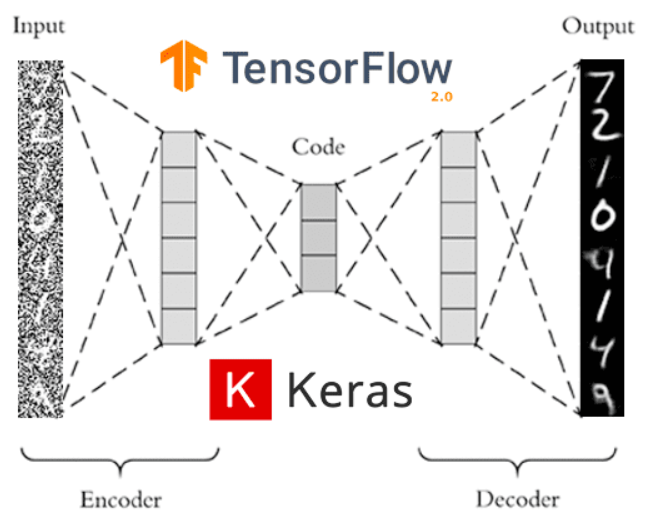

 Because of the previous notebook has all explanation about creating encoder, decoder and autoencoder, In here I will just copy paste same codes. The importing part is the dataset preperation. Until that point, all steps are same with the previous notebook (can be found in 2_keras_autoencoders my github)

In [1]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

In [2]:
# our model will train on mnist dataset. because of that dimensions of input 
inputShape = (28, 28, 1)

#channel is at the end
chanDim = -1

#our latent representation will be 16 dims
latentDim=16

In [3]:
inputs = Input(shape=inputShape)
x = inputs
#first Conv layer 32 filters
x = Conv2D(32, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)
#second Conv layer 64 filters
x = Conv2D(64, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

In [4]:
# flatten the network and then construct our latent vector
volumeSize = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latentDim)(x)

# build the encoder model
encoder = Model(inputs, latent, name="encoder")

In [5]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                           

In [6]:
#output of encoder will be our input for decoder
latentInputs = Input(shape=(latentDim,))
x = Dense(np.prod(volumeSize[1:]))(latentInputs)
x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)


In [7]:
#transpose conv for reverse 
x = Conv2DTranspose(64, (3, 3), strides=2,padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)
x = Conv2DTranspose(32, (3, 3), strides=2,padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

In [8]:
#apply a single CONV_TRANSPOSE layer used to recover the original shape
x = Conv2DTranspose(1, (3, 3), padding="same")(x)
outputs = Activation("sigmoid")(x)

In [9]:
# build the decoder model
decoder = Model(latentInputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_1 (Dense)             (None, 3136)              53312     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                           

In [10]:
# our autoencoder is the encoder + decoder
autoencoder = Model(inputs, decoder(encoder(inputs)),name="autoencoder")

In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

In [12]:
# initialize the number of epochs to train for and batch size
EPOCHS = 25
BS = 32

# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()

trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

[INFO] loading MNIST dataset...


In [13]:
# sample noise from a random normal distribution centered at 0.5 (since
# our images lie in the range [0, 1]) and a standard deviation of 0.5
trainNoise = np.random.normal(loc=0.5, scale=0.5, size=trainX.shape)
testNoise = np.random.normal(loc=0.5, scale=0.5, size=testX.shape)
trainXNoisy = np.clip(trainX + trainNoise, 0, 1)
testXNoisy = np.clip(testX + testNoise, 0, 1)

#np.clip Clip (limit) the values in an array.
# np.random.normal Draw random samples from a normal (Gaussian) distribution.

In [14]:
EPOCHS = 25
BS = 32
opt = Adam(learning_rate=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

In [15]:
# train the convolutional autoencoder
H = autoencoder.fit(trainXNoisy, trainX,validation_data=(testXNoisy, testX),epochs=EPOCHS,batch_size=BS)

Epoch 1/25
1875/1875 [==============================] - 18s 8ms/step - loss: 0.0288 - val_loss: 0.0190
Epoch 2/25
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0187 - val_loss: 0.0179
Epoch 3/25
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0177 - val_loss: 0.0177
Epoch 4/25
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0171 - val_loss: 0.0170
Epoch 5/25
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0166 - val_loss: 0.0171
Epoch 6/25
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0163 - val_loss: 0.0166
Epoch 7/25
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0161 - val_loss: 0.0170
Epoch 8/25
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0159 - val_loss: 0.0178
Epoch 9/25
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0157 - val_loss: 0.0158
Epoch 10/25
1875/1875 [==============================] - 15s 8ms/step - l

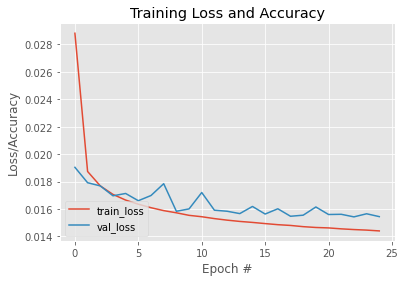

In [16]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('denoise_autoencoder.png')

In [18]:
print("[INFO] making predictions...")
decoded = autoencoder.predict(testXNoisy)
outputs = None

# loop over our number of output samples
for i in range(0,8):
# grab the original image and reconstructed image
    original = (testXNoisy[i] * 255).astype("uint8")
    recon = (decoded[i] * 255).astype("uint8")

# stack the original and reconstructed image side-by-side
    output = np.hstack([original, recon])

# if the outputs array is empty, initialize it as the current
# side-by-side image display
    if outputs is None:
        outputs = output

        # otherwise, vertically stack the outputs
    else:
        outputs = np.vstack([outputs, output])

# save the outputs image to disk
cv2.imwrite('result_denoise.png', outputs)

[INFO] making predictions...


True

Result_denoise.png looks like : 

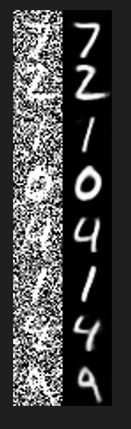

In [19]:
autoencoder.save('mnist_denoise.hdf5')

FOR MORE TRY THESE DATASET : 
    https://www.kaggle.com/competitions/denoising-dirty-documents/data
        